<a href="https://colab.research.google.com/github/yalexie1/Data-Science/blob/main/Unit6/YaleXie_Unit6Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Introduction

For my Unit 6 project, I will be creating a linear model with **multiple predictors** to predict **Walmart's yearly stock price change** from three factors: **MKT, SMB, and HML**. I thought this topic would be interesting because I recently did a digital apprenticeship for a quant hedge fund and I extensively read and analyzed these factors and their role in risk analysis and portfolio management.

**Extra Information:**

The three factors I just mentioned (MKT, SMB, HML) are actually previously defined factors for stock returns from Eugene Fama and Kenneth French's groundbreaking finance paper *Common Risk Factors in the Returns of Stocks and Bonds* (1992). This paper introduced two additional factors to the original Capital Asset Pricing Model (CAPM), which only had one factor: MKT, or the excess return of a general market portfolio over the risk-free rate. SMB stands for "Small Minus Big" and it describes the excess returns of small-cap stocks over large-cap stocks. HML stands for "High Minus Low" and it describes the excess returns of high book-to-market equity ratio stocks to low book-to-market equity ratio stocks. Together, they account for approximately 90-95% of a stock's expected returns. The Fama-French Three-Factor Model is a robust way of checking portfolios are being well managed: a significant positive alpha (returns unexplained by the three factors) indicates that the portfolio manager is performing well.

In [ ]:
!pip install git+https://github.com/pydata/xarray.git
import xarray as xr
!pip install bambi
import bambi as bmb

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

# Part II: Data

The data I am using comes from **Kenneth French's website and the MacroTrends website**. Let's upload the data by reading the **csv file** I created by combining the data from the two websites.

In [3]:
ff_data = pd.read_csv("https://raw.githubusercontent.com/xeqoir/Data-Science/refs/heads/main/Unit6/Unit6Data%20-%20FamaFrenchThreeFactorsMonthly.csv")
ff_data.head(10) # ff_data means "Fama-French data"

,Year,MKT,SMB,HML,Change
0,1973,-26.18,-23.51,17.47,-61.48
1,1974,-35.75,-0.81,9.96,-28.85
2,1975,32.44,15.41,9.14,178.38
3,1976,21.91,14.67,24.38,17.48
4,1977,-8.26,22.62,7.46,30.58
5,1978,1.03,14.42,0.67,12.66
6,1979,13.09,21.27,-2.33,46.07
7,1980,22.13,5.66,-24.61,81.92
8,1981,-18.13,7.11,25.04,40.59
9,1982,10.66,8.68,13.29,134.74


# Part III: Multiple Linear Models (Combinations)

We will be using the Python library Bambi to create our multi-linear models. I will create five different combinations of the three factors and use elpd_loo to check which model performs the best at the end. The five combinations I will use are as follows:

1. MKT, SMB, HML (no interactions)
2. MKT, SMB, HML, and interactions between all three (two at a time)
3. MKT, SMB, HML, interaction between MKT and SMB
4. MKT, SMB, HML, interaction between MKT and HML
5. MKT, SMB, HML, interaction between SMB and HML
6. MKT, SMB, HML, and interactions between all three (all three at the same time)

In [ ]:
#define the model
model_1 = bmb.Model("`Change` ~ `MKT` + `SMB` + `HML`", data=ff_data)
#fit the model
idata_1 = model_1.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_2 = bmb.Model("`Change` ~ `MKT` + `SMB` + `HML` + `MKT` : `SMB` + `MKT` : `HML` + `SMB`: `HML`", data=ff_data)
#fit the model
idata_2 = model_2.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_3 = bmb.Model("`Change` ~ `MKT` + `SMB` + `HML` + `MKT` : `SMB`", data=ff_data)
#fit the model
idata_3 = model_3.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_4 = bmb.Model("`Change` ~ `MKT` + `SMB` + `HML` + `MKT` : `HML`", data=ff_data)
#fit the model
idata_4 = model_4.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_5 = bmb.Model("`Change` ~ `MKT` + `SMB` + `HML` + `SMB` : `HML`", data=ff_data)
#fit the model
idata_5 = model_5.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='SMB', ylabel='Change'>], dtype=object))

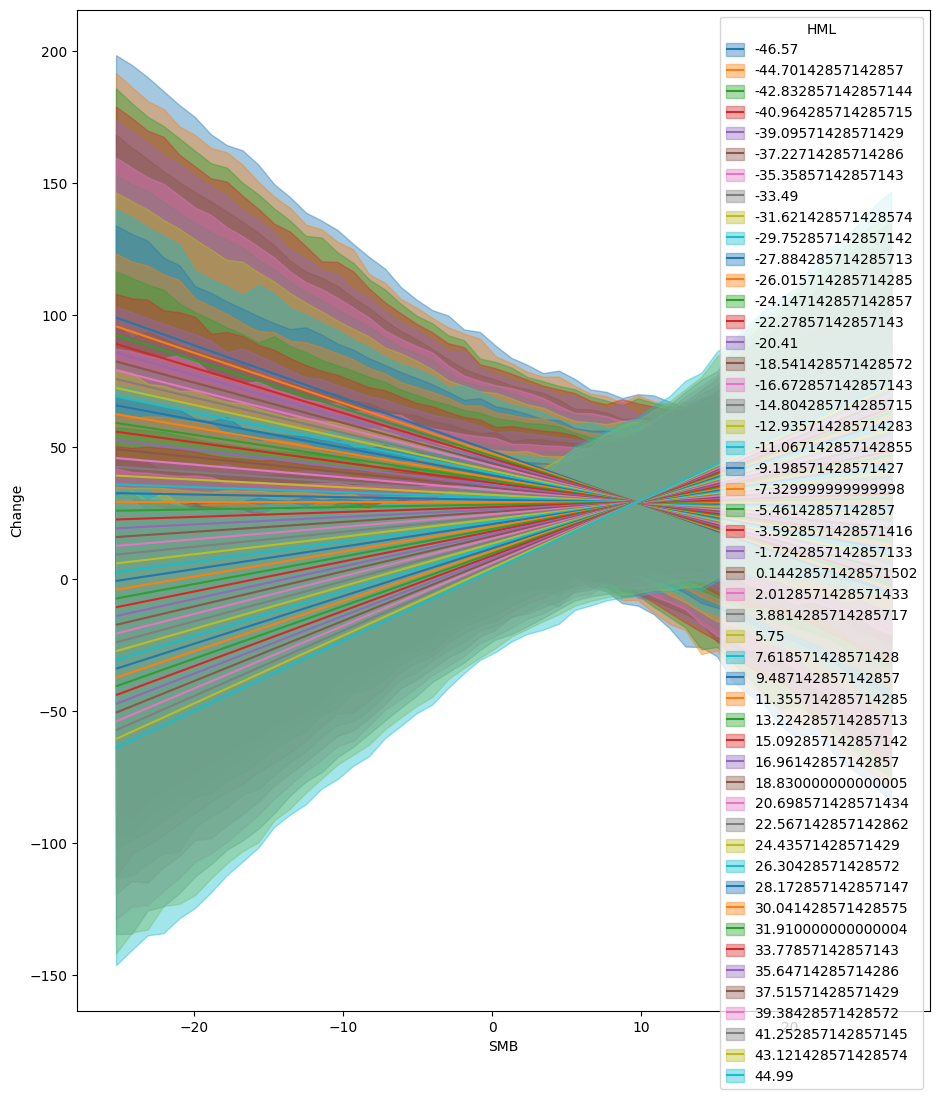

In [9]:
bmb.interpret.plot_predictions(model_5,
                               idata_5,
                               ["SMB","HML"],
                               fig_kwargs={"figsize":(11, 13)})#,
                               #legend=False)

In [ ]:
#define the model
model_6 = bmb.Model("`Change` ~ `MKT` + `SMB` + `HML` + `MKT` : `SMB` : `HML`", data=ff_data)
#fit the model
idata_6 = model_6.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
cmp = az.compare({"1":idata_1,"2":idata_2, "3":idata_3, "4":idata_4, "5":idata_5, "6":idata_6})

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

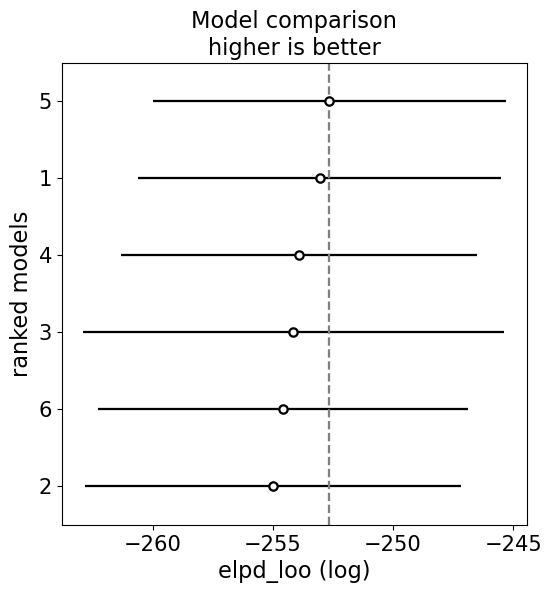

In [12]:
az.plot_compare(cmp)

# Part IV: Discussion

It seems that the models all did pretty similar to each other, but 1 and 5 are the best. Model 1 doing well makes sense; these factors were not meant to have significant ties to each other and this reflects that truth. However, Model 5 (interaction between SMB and HML) makes a little less sense, until we delve into the causal diagram. As it turns out, both SMB and HML are relatively affected by public sentiment, since that is ultimately what determines market cap and BME ratio. Therefore, it makes some sense that connecting those two would perhaps work in favor of the model.

However, it's not entirely clear whether this is just a coincedence with Walmart, since I'm sure Fama and French have studied this deeply enough to make a professional judgement (since they even came out with an additional Five-Factor model in 2015). I think further research would have to be done to see if this is just a one-time off or it is actually a pattern worth noting.